## ResNet을 이용하여 CAM 적용하기.

In [11]:
import torch
from torchvision import datasets, models, transforms
import urllib.request
import ast
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch.nn.functional as F

참고문서
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [2]:
## Resnet은 ImageNet에서 Training 되었으므로 image Net의 class 정보를 가져옵니다.
classes_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

In [3]:
## class 정보 불러오기
with urllib.request.urlopen(classes_url) as handler:
    data = handler.read().decode()
    classes = ast.literal_eval(data)

In [4]:
## Resnet 불러오기
model_ft = models.resnet18(pretrained=True)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
## 불러올 이미지를 선택합니다.
img_path = 'cat.jpg'

In [6]:
## Imagenet Transformation 참조
## https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    ## Resize는 사용하지 않고 원본을 추출
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

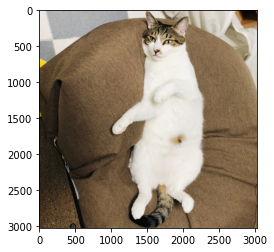

In [7]:
## 그림을 불러옵니다.
raw_img = Image.open(img_path)
plt.imshow(raw_img)
plt.show()

In [8]:
## 이미지를 전처리 및 변형
img_input = preprocess(raw_img)

## 모델 결과 추출
output = model_ft(img_input.unsqueeze(0))

In [12]:
## 클래스 추출
softmaxValue = F.softmax(output)
class_id=int(softmaxValue.argmax().numpy())
print("결과 : {}".format(classes[class_id]))

결과 : Egyptian cat


<ipython-input-12-3295cf2581c0>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxValue = F.softmax(output)


In [13]:
## Resnet 구조 참고
## https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def get_activation_info(self, x):
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    return x

In [14]:
## Feature Map 추출
feature_maps = get_activation_info(model_ft, img_input.unsqueeze(0)).squeeze().detach().numpy()
## Weights 추출
activation_weights = list(model_ft.parameters())[-2].data.numpy()
print("Feature MAP(모양) : {}".format(feature_maps.shape), "Weights(모양) : {}".format(activation_weights.shape))

Feature MAP(모양) : (512, 7, 7) Weights(모양) : (1000, 512)


In [15]:
## numpy 이미지
#numpy_img = img_input.detach().numpy().transpose(1, 2, 0)
numpy_img = np.asarray(raw_img)

In [16]:
def show_CAM(numpy_img, feature_maps, activation_weights, classes, class_id):
    ## CAM 추출
    cam_img = np.matmul(activation_weights[class_id], feature_maps.reshape(feature_maps.shape[0], -1)).reshape(feature_maps.shape[1:])
    cam_img = cam_img - np.min(cam_img)
    cam_img = cam_img/np.max(cam_img)
    cam_img = np.uint8(255 * cam_img)
    
    ## Heat Map으로 변경
    heatmap = cv2.applyColorMap(cv2.resize(255-cam_img, (numpy_img.shape[1], numpy_img.shape[0])), cv2.COLORMAP_JET)
    
    ## 합치기
    result = numpy_img * 0.5 + heatmap * 0.3
    result = np.uint8(result)
    
    fig=plt.figure(figsize=(16, 8))
        
    ## 원본 이미지
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(numpy_img)
       
    ## CAM 이미지
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(result)
    
    plt.suptitle("[{}] CAM Image".format(classes[class_id]), fontsize=30)
    
    plt.show()  

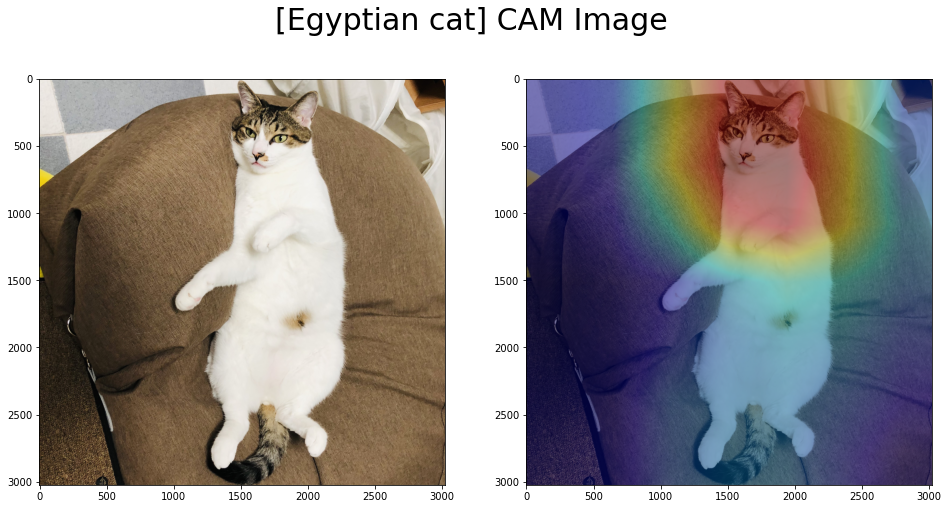

In [17]:
show_CAM(numpy_img, feature_maps, activation_weights, classes, class_id)

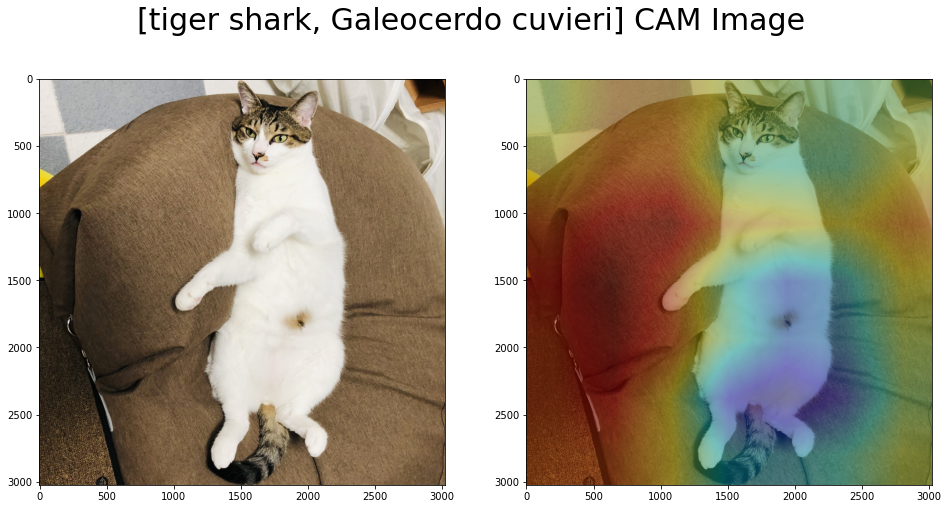

In [18]:
show_CAM(numpy_img, feature_maps, activation_weights, classes, 3)